# Experiments with asyncio pipeline

Ref: [Pipeline setup](https://www.dreamonward.com/2019/07/25/asyncio-pipeline/)


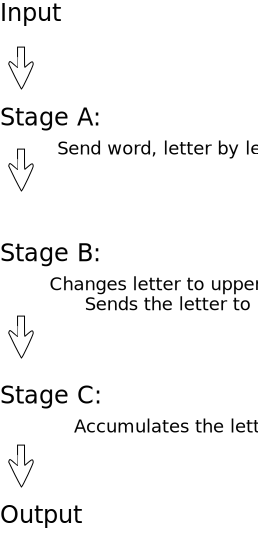

In [1]:
from IPython.core.display import SVG
SVG(filename='flow.svg')

In [2]:
"""
Example program for basic asyncio pipeline.

Program takes string as input and converts it to upper case.

For sake of simplicity missing some "features", most notably error handling is absent.
Errors will silenty prevent program completion in many cases.
"""
import asyncio
from dataclasses import dataclass

@dataclass()
class DataAB:
    letter: str


@dataclass()
class DataBC:
    letter: str
    upper: str


result = ""


async def do_stepA(queue_out, input):
    for letter in input:
        print(f'A, sending {letter}')
        await queue_out.put(DataAB(letter))


async def do_stepB(queue_in, queue_out):
    while True:
        data: DataAB = await queue_in.get()

        # perform actual step
        letter = data.letter
        upper = letter.upper()
        print(f'B, processed {upper}')

        await queue_out.put(DataBC(letter, upper))

        queue_in.task_done()


async def do_stepC(queue_in):
    global result
    while True:
        data: DataBC = await queue_in.get()

        # perform actual step
        letter = data.letter
        upper = data.upper
        print(f'C, {letter} changed to {upper}')

        result += upper

        queue_in.task_done()


async def main():
    pipeline_in = 'hello world'

    print(f'converting to upper case: {pipeline_in}')

    queue_AB = asyncio.Queue()
    queue_BC = asyncio.Queue()

    stepA = asyncio.create_task(do_stepA(queue_AB, pipeline_in))
    stepB = asyncio.create_task(do_stepB(queue_AB, queue_BC))
    stepC = asyncio.create_task(do_stepC(queue_BC))

    await stepA
    print('step A done')

    await queue_AB.join()
    print('queue A - B done')
    stepB.cancel()  # no more date is going to show up at B

    await queue_BC.join()
    print('queue B - C done')
    stepC.cancel()  # no more date is going to show up at C

    print(f'main complete, result: {result}')

await main()

print('program complete')

converting to upper case: hello world
A, sending h
A, sending e
A, sending l
A, sending l
A, sending o
A, sending  
A, sending w
A, sending o
A, sending r
A, sending l
A, sending d
B, processed H
B, processed E
B, processed L
B, processed L
B, processed O
B, processed  
B, processed W
B, processed O
B, processed R
B, processed L
B, processed D
C, h changed to H
C, e changed to E
C, l changed to L
C, l changed to L
C, o changed to O
C,   changed to  
C, w changed to W
C, o changed to O
C, r changed to R
C, l changed to L
C, d changed to D
step A done
queue A - B done
queue B - C done
main complete, result: HELLO WORLD
program complete
